# Classify scintillated signals using CNN

First, we import some Python packages and define the parameters of the image frames.

In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../../setigen")
import setigen as stg

tsamp = 1.0
fch1 = 6095.214842353016
df = -1.0e-06

fchans = 1024
tchans = 32

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

Then, we load the model weights for each normalization method.

In [2]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.preprocessing import image

img_width, img_height = 32, 1024

dir = 'scintillated'

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_path = '/datax/scratch/bbrzycki/models/%s/scintillated.h5' % (dir)
model.load_weights(model_path)


Using TensorFlow backend.


Now, we can generate signals to test our models and see which normalization schemes work best. Note that since these are all synthetic and use ideal Gaussian background noise, these might perform differently for actual observations!

#### Classify scintillated signal

Period: 3.09 s
Drift Rate: 25.84 Hz/s
Level: 1.44
Width: 783083.46 Hz


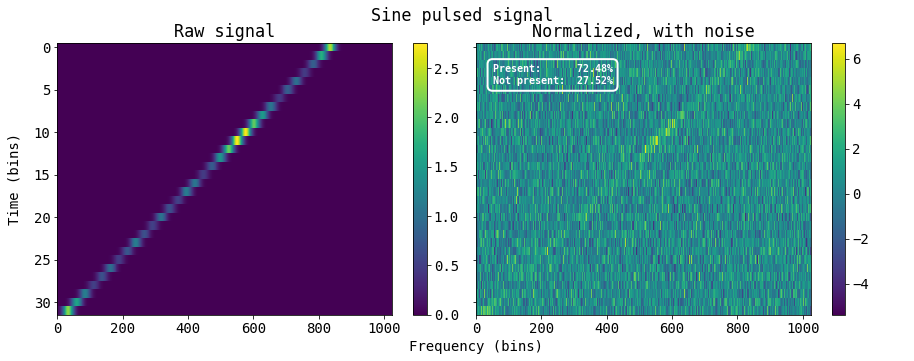

In [17]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.05) ** 3
#drift_rate = 0
level = np.random.uniform(1,5)
period = np.random.uniform(2,4)
phase = np.random.uniform(0,period)
sigma = np.random.uniform(0.1, 2)
pulse_dir = 'rand'
width = np.random.uniform(np.random.uniform(0.1,2))
pnum = 10
amplitude = np.random.uniform(min(1, level/2.), level)
# amplitude = np.random.uniform(min(1, level/2.), level/2)

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum, amplitude, level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0),
                      integrate = True)

# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Period: %.02f s' % period)
print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(noisy, aspect='auto')
plt.imsave('temp_noisy.png', noisy)
ax2.set_title('Normalized, with noise')

img2 = load_img('temp_noisy.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.6
else:
    x_pos = 0.05
    
text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
                                                                     value1='%.02f%%' % (prob2[1]*100),
                                                                     constant='Not present:',
                                                                     value2='%.02f%%' % (prob2[0]*100))    
ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Sine pulsed signal')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Classify constant signal

Drift Rate: 25.39 Hz/s
Level: 3.21
Width: 783083.46 Hz


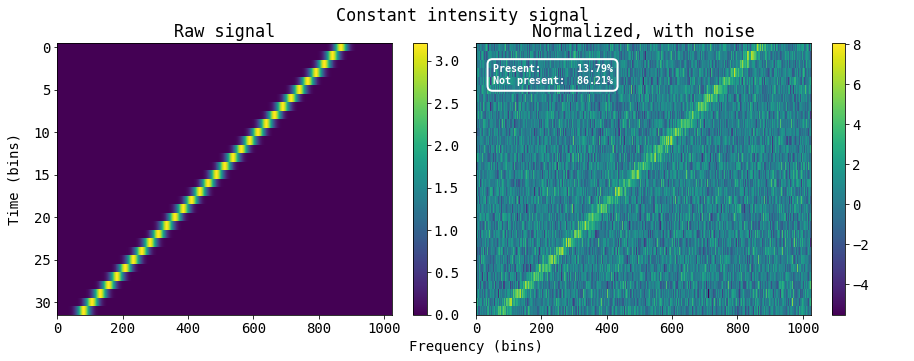

In [25]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.05) ** 3
level = np.random.uniform(1,5)

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0))
# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(noisy, aspect='auto')
plt.imsave('temp_noisy.png', noisy)
ax2.set_title('Normalized, with noise')

img2 = load_img('temp_noisy.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.6
else:
    x_pos = 0.05
    
text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
                                                                     value1='%.02f%%' % (prob2[1]*100),
                                                                     constant='Not present:',
                                                                     value2='%.02f%%' % (prob2[0]*100))    
ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Constant intensity signal')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Classify noise

Drift Rate: -14.00 Hz/s
Level: 1.01
Width: 1500268.06 Hz


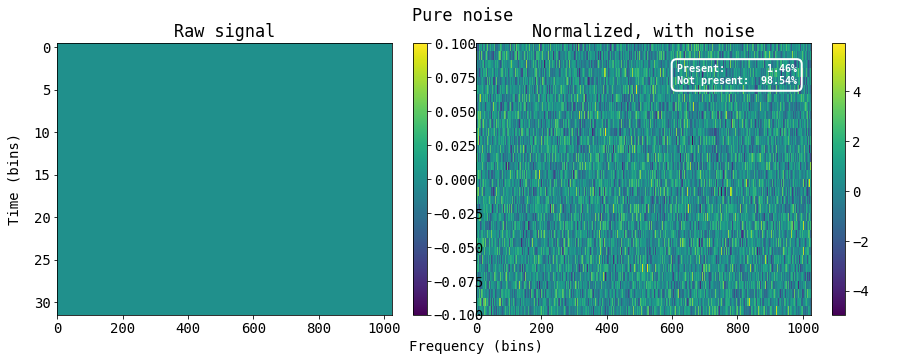

In [13]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
line_width = np.random.uniform(0.02, 0.05) ** 3
level = np.random.uniform(1,5)

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = 0),
                      stg.gaussian_f_profile(width = line_width),
                      stg.constant_bp_profile(level = 1.0))
# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharex='col', sharey='row')

img1a = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

noisy = stg.normalize(stg.inject_noise(signal), cols = 128, exclude = 0.2, use_median=False)
img2a = ax2.imshow(noisy, aspect='auto')
plt.imsave('temp_noisy.png', noisy)
ax2.set_title('Normalized, with noise')

img2 = load_img('temp_noisy.png',False,target_size=(32,1024))
x = img_to_array(img2)
x = x / 255.
x = np.expand_dims(x, axis=0)
prob2 = model.predict_proba(x)[0]

# prob2 = (0.9567, 0.1083)
# prob3 = (0.9567, 0.1083, 0.0032)
# prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.6
else:
    x_pos = 0.05
    
text = '{pulsed:<12} {value1:>7}\n{constant:<12} {value2:>7}'.format(pulsed='Present:',
                                                                     value1='%.02f%%' % (prob2[1]*100),
                                                                     constant='Not present:',
                                                                     value2='%.02f%%' % (prob2[0]*100))    
ax2.text(x_pos, 0.85, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Pure noise')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1a, ax = ax1)
plt.colorbar(img2a, ax = ax2)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Look at actual data!